## Circuits

In [1]:
from qiskit import QuantumCircuit
import numpy as np

class MarkovChain(QuantumCircuit):
    '''Markov Chain Sub-circuit. Params:
        time_steps: The number of Markov Chain time steps after the steady state
        prob_gb: transition probability from the good state to the bad state
        prob_bg: transition probability from the bad state to the good state'''
    def __init__(self, time_steps, prob_gb, prob_bg):
        
        #define rotation angles
        theta_naught = 2*np.arccos(np.sqrt((prob_bg)/(prob_gb+prob_bg)))
        theta_0 = 2*np.arccos(np.sqrt(1-prob_gb))
        theta_1 = 2*np.arccos(np.sqrt(prob_bg))
        
        #create circuit
        n = time_steps+1
        circ = QuantumCircuit(n)
        
        #steady state
        circ.ry(theta_naught, [0],'theta_naught')
        
        #transition rotations
        for i in range(n-1):
            circ.ry(theta_0, [i+1], 'theta_0')
            circ.cry(theta_1 - theta_0, [i], [i+1], 'theta_1')
            
        super().__init__(circ.num_qubits,name='MC')
        self.append(circ.to_gate(),range(circ.num_qubits)) 

In [2]:
from typing import List
from qiskit.circuit.library import StatePreparation

In [3]:
def generate_random_transition_matrix(x):
    # Generate a random matrix
    random_matrix = np.random.rand(x, x)
    # Normalize each row to sum to 1
    
    transition_matrix = random_matrix / random_matrix.sum(axis=0, keepdims=True)
    return transition_matrix

def find_steady_state(P):
    n = P.shape[0]
    # Subtract the identity matrix from P
    A = P.T - np.eye(n)
    # Add an additional constraint to ensure the probabilities sum to 1
    A = np.vstack([A, np.ones(n)])
    b = np.zeros(n)
    b = np.append(b, 1)
    # Solve the linear system
    steady_state = np.linalg.lstsq(A, b, rcond=None)[0]
    return steady_state

x = 4
transition_matrix = generate_random_transition_matrix(x)

print([np.linalg.norm(np.sqrt(state)) for state in transition_matrix.T])

steady_state = find_steady_state(transition_matrix)
print(transition_matrix)

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
[[0.3316366  0.32587383 0.04132316 0.08848415]
 [0.15826125 0.30238891 0.29428876 0.09748659]
 [0.43328014 0.22007308 0.25428039 0.57451691]
 [0.07682201 0.15166418 0.41010769 0.23951235]]


[[0.3316366  0.32587383 0.04132316 0.08848415]
 [0.15826125 0.30238891 0.29428876 0.09748659]
 [0.43328014 0.22007308 0.25428039 0.57451691]
 [0.07682201 0.15166418 0.41010769 0.23951235]]
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


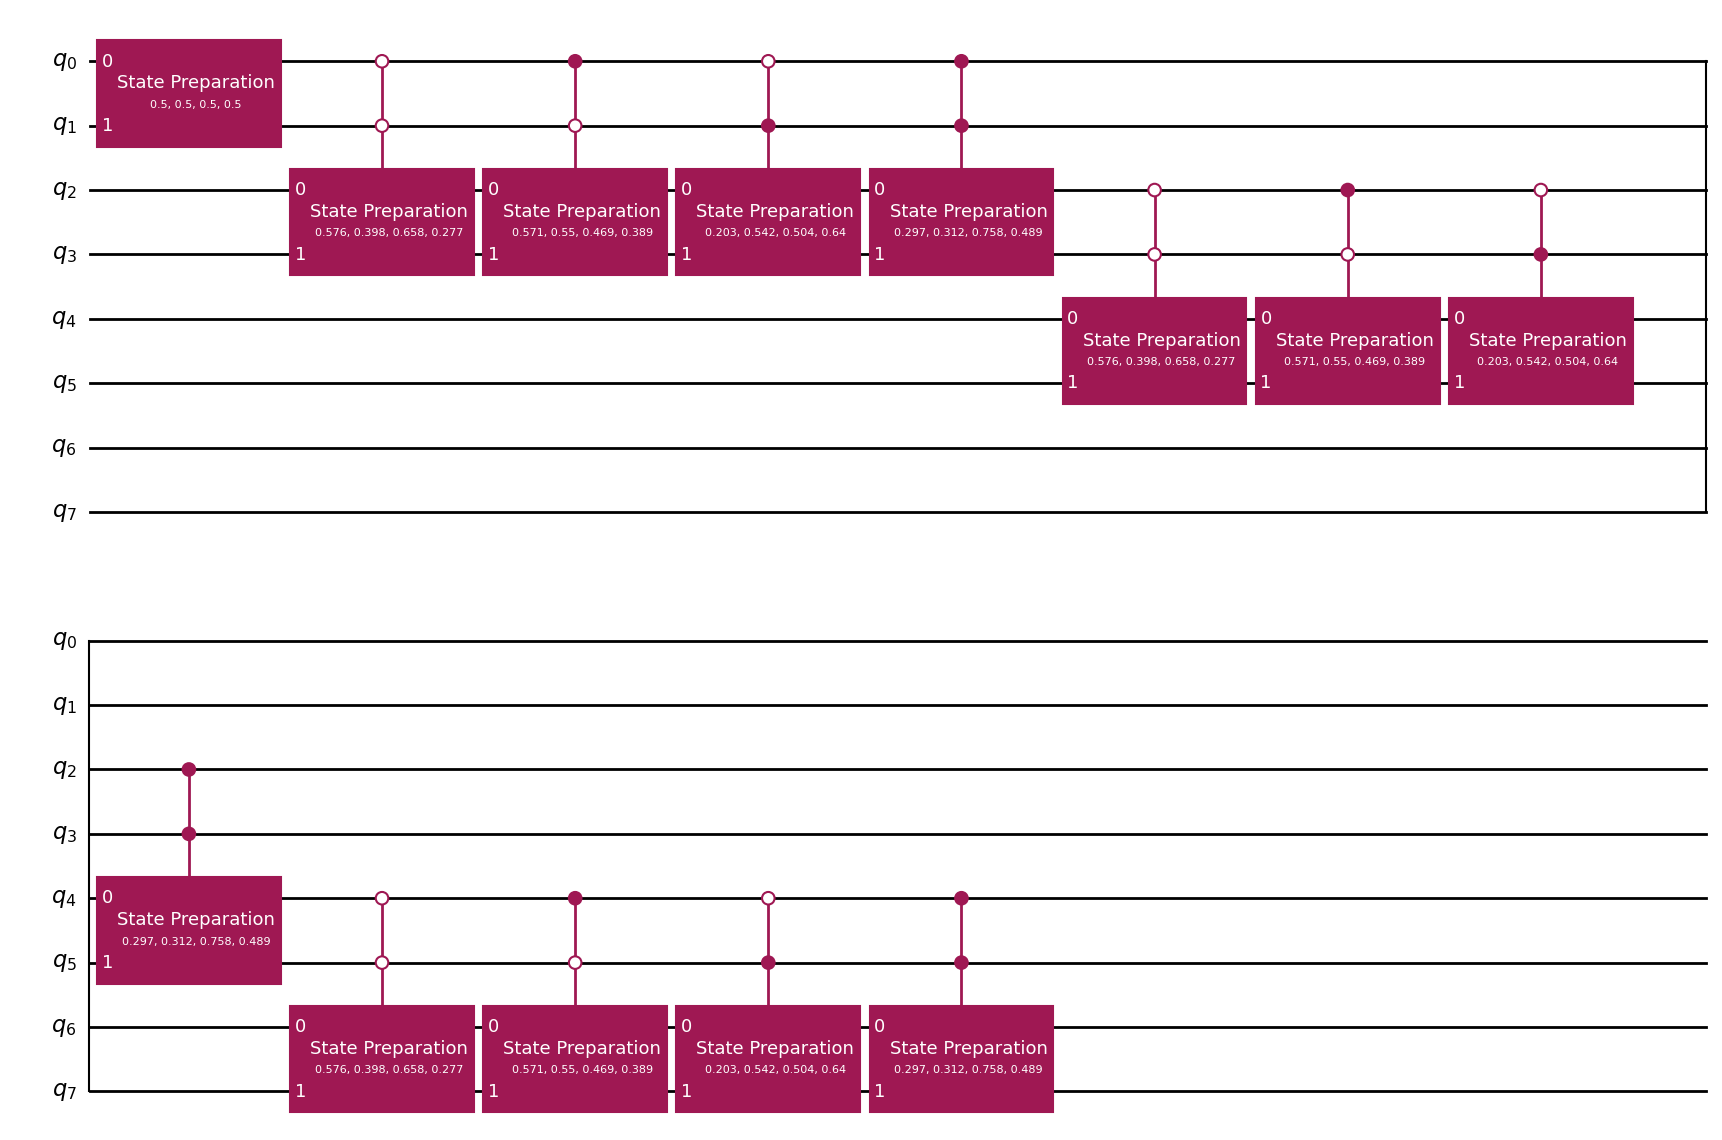

In [4]:
def MarkovChainBinary(num_time_steps: int, 
                      transition_matrix: List[List[float]],
                      steady_state: List[float]):
    steady_state = steady_state/np.linalg.norm(steady_state)
    print(transition_matrix)
    transition_states = [list(np.sqrt(state)) for state in transition_matrix.T]
    print([np.linalg.norm(state) for state in transition_states])
    num_state_qubits = int(np.ceil(np.log2(len(transition_states[0]))))

    #print([(np.linalg.norm(np.sqrt(state)), list(state)) for state in transition_probs])

    gates = [StatePreparation(state) for state in transition_states]   
    circ = QuantumCircuit(num_state_qubits*(num_time_steps+1))
    circ.prepare_state(steady_state, range(num_state_qubits))

    qubits = list(range(2*num_state_qubits))

    for _ in range(num_time_steps):
        for state, gate in enumerate(gates):
            circ.append(gate.control(ctrl_state=state, num_ctrl_qubits=num_state_qubits), qubits)
        qubits = [qubit+num_state_qubits for qubit in qubits]
    return circ

num_time_steps = 3

test = MarkovChainBinary(num_time_steps=num_time_steps,
                         transition_matrix=transition_matrix,
                         steady_state=steady_state)
test.draw('mpl')  

In [18]:
def MarkovChainOneHot(num_time_steps: int, 
                      transition_matrix: List[List[float]],
                      steady_state: List[float]):
    steady_state = steady_state/np.linalg.norm(steady_state)
     = [2*np.arccos(np.sqrt(1-prob)) for prob in steady_state]
    print(transition_matrix)
    rotation_angles = [[2*np.arccos(np.sqrt(1-prob)) for prob in state] for state in transition_matrix.T]
    num_state_qubits = int(len(rotation_angles[0]))

    circ = QuantumCircuit(num_state_qubits*(num_time_steps+1))
    circ.prepare_state(steady_state, range(num_state_qubits))

    start_qubit = 0

    for _ in range(num_time_steps):
        for qubit0 in range(num_state_qubits):
            thetas = rotation_angles[qubit0]
            for qubit1 in range(num_state_qubits):
                theta = thetas[qubit1]
                control_qubit = start_qubit+qubit0
                target_qubit = start_qubit+num_state_qubits+qubit1
                circ.cry(theta, control_qubit, target_qubit)
        start_qubit+=num_state_qubits
    return circ

num_time_steps = 3

test = MarkovChainOneHot(num_time_steps=num_time_steps,
                         transition_matrix=transition_matrix,
                         steady_state=steady_state)
test.draw('mpl')  

[[0.3316366  0.32587383 0.04132316 0.08848415]
 [0.15826125 0.30238891 0.29428876 0.09748659]
 [0.43328014 0.22007308 0.25428039 0.57451691]
 [0.07682201 0.15166418 0.41010769 0.23951235]]


QiskitError: 'StatePreparation parameter vector has 4 elements, therefore expects 2 qubits. However, 4 were provided.'

In [5]:
from qiskit import transpile
from qiskit.providers.fake_provider import FakeTorino

In [11]:
fake_torino = Fake127QPulseV1()
binary_test = MarkovChainBinary(num_time_steps=num_time_steps,
                                transition_matrix=transition_matrix,
                                steady_state=steady_state,
                                )
one_hot_test = 1

[[0.3316366  0.32587383 0.04132316 0.08848415]
 [0.15826125 0.30238891 0.29428876 0.09748659]
 [0.43328014 0.22007308 0.25428039 0.57451691]
 [0.07682201 0.15166418 0.41010769 0.23951235]]
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


In [10]:
binary_t = transpile(binary_test, fake_backend)
print(binary_t.count_ops())

OrderedDict([('cx', 1383), ('rz', 808), ('sx', 458), ('x', 14)])


In [13]:
print(fake_torino.basis_gates)

AttributeError: 'Fake127QPulseV1' object has no attribute 'basis_gates'

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

ppm = generate_preset_pass_manager(optimization_level=3, 
                                   basis_gates = ["id", "rz", "sx", "x", "cx", "reset"],
                                   )

In [16]:
all_to_all_binary = ppm.run(binary_test)
all_to_all_binary.count_ops()

OrderedDict([('rz', 807), ('cx', 624), ('sx', 458), ('x', 14)])

In [2]:

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit

from qiskit.circuit.library import QFT, LinearAmplitudeFunction
from typing import Optional
import numpy as np




class DerivativePricing(QuantumCircuit):   
    '''Derivative Pricing Sub-circuit. Params:
        strike_price: strike price of the derivative.
        time_steps: The number of Markov Chain time steps after the steady state.
        prob_gb: transition probability from the good state to the bad state.
        prob_bg: transition probability from the bad state to the good state.
        integer_precision: the number of qubits before the decimal used to hold the price of the derivative.
        fractional_precision: the number of qubits after the decimal used to hold the price of the derivative.
        r: The interest rate of a risk free asset in each regime.
        sigma_off: The volitility of the market in each regime.'''
        
    def _AdderBaseQFT(self, value):
        '''Sub-circuit that adds the constant value to the price register in the QFT basis'''
        circ_a = QuantumCircuit(self.num_size)
        for i in range(self.num_size):
            lam = value * (2**self.fractional_precision) * np.pi / (2**(i))
            circ_a.p(lam, i)
        return circ_a.to_gate(label='Add Value')

    def _MCBinTree(self):
        '''Markov Chain Binomial Tree sub circuit that adds the appropriate growth possibility for each combination
        of the Markov Chain and binomial tree'''
        #model parameters
        dt = 1/12 # using 1 month transition probabilities
        sigma_off = self.sigma_off
        r = self.r


        circ_b = QuantumCircuit(1+(2*self.time_steps)+self.num_size)

        for i in range(self.time_steps):

            # set parameters in good regime
            sigma = sigma_off[0]+min(max(1.2*i*dt,0),0.1)
            mu = r[0] - ((sigma**2)/2)

            # add appropriate log growths "up" and "down"
            lu = (mu*dt)+(sigma*np.sqrt(dt))
            ld = (mu*dt)-(sigma*np.sqrt(dt))

            lucirc = self._AdderBaseQFT(lu).control(num_ctrl_qubits=2, ctrl_state='00')
            ldcirc = self._AdderBaseQFT(ld).control(num_ctrl_qubits=2, ctrl_state='10')

            circ_b.append(lucirc, [i+1,self.time_steps+1+i]+list(range(-self.num_size,0,1)))
            circ_b.append(ldcirc, [i+1,self.time_steps+1+i]+list(range(-self.num_size,0,1)))

            # set parameters in bad regime
            sigma = sigma_off[1]+min(max(1.2*i*dt,0),0.1)
            mu = r[1] - ((sigma**2)/2)

            #add appropriate log growths "up" and "down"
            lu = (mu*dt)+(sigma*np.sqrt(dt))
            ld = (mu*dt)-(sigma*np.sqrt(dt))

            lucirc = self._AdderBaseQFT(lu).control(num_ctrl_qubits=2, ctrl_state='01')
            ldcirc = self._AdderBaseQFT(ld).control(num_ctrl_qubits=2, ctrl_state='11')

            circ_b.append(lucirc, [i+1,self.time_steps+1+i]+list(range(-self.num_size,0,1)))
            circ_b.append(ldcirc, [i+1,self.time_steps+1+i]+list(range(-self.num_size,0,1)))

        return circ_b.to_gate(label='Price Evolution')

    def _Payoff(self):
        # Calculate appropriate strike price and maximum price
        f_max = ((2**(self.integer_precision+1))-(2.0**(-self.fractional_precision)))
        po_max = f_max - self.strike_price

        #retuen LinearAmplitudeFunction
        circ_p = LinearAmplitudeFunction(
            num_state_qubits=self.integer_precision+self.fractional_precision+1,
            slope=[0,1],
            offset=[0,0],
            domain=(0, f_max),
            image=(0, po_max),
            breakpoints=[0,self.strike_price],
            rescaling_factor=self.c_approx,
        )
        return circ_p

    def __init__(self,
        strike_price: float,
        time_steps: int,
        prob_gb: Optional[float] = 0.1,
        prob_bg: Optional[float] = 0.3,
        integer_precision: Optional[int] = 1,
        fractional_precision: Optional[int] = 4,
        starting_price: Optional[float] = 1.0,
        r: Optional[list[float]] = [0.2,0.1],
        sigma_off: Optional[list[float]] = [0.2,0.3],
        c_approx: Optional[float] = 0.05,
        name: Optional[str] = 'DP'
        ):               


        self.strike_price = strike_price
        self.time_steps = time_steps
        self.integer_precision = integer_precision
        self.fractional_precision = fractional_precision
        self.num_size = integer_precision+fractional_precision+1
        self.starting_price = starting_price
        self.time_tot = time_steps/12 # using transition probabilities from month to month
        self.r = r
        self.c_approx = c_approx # constant used for rescaling in Linear Amplitude Function
        self.f_max = ((2**self.integer_precision)-(2.0**(-self.fractional_precision))) # maximum
        self.sigma_off = sigma_off

        payoff = self._Payoff()
        qubits = 1+(2*time_steps)+payoff.num_qubits

        self.post_processing = payoff.post_processing
        self.objective = qubits-payoff.num_ancillas-1

        circ = QuantumCircuit(qubits)

        circ.append(MarkovChain(time_steps,prob_gb,prob_bg).to_gate(),range(time_steps+1)) #prepare Markov Chain

        circ.h(range(1+time_steps,1+(2*time_steps))) #prepare binomial tree

        circ.append(QFT(self.num_size,0,do_swaps=False, inverse=False, insert_barriers=False).to_gate(), 
                    range(1+(2*time_steps),1+(2*time_steps)+self.num_size)) #switch price register to base QFT

        '''We calculate exolution of the price in log space,
        then convert at the end using e^x approx 1+x'''
        # add the initial price of the derivative
        circ.append(self._AdderBaseQFT(np.log(starting_price)),
                    range(1+(2*time_steps),1+(2*time_steps)+self.num_size)) 
        # add the evolution in price
        circ.append(self._MCBinTree(),
                    range(1+(2*time_steps)+self.num_size))

        circ.append(self._AdderBaseQFT(1),
                    range(1+(2*time_steps),1+(2*time_steps)+self.num_size)) #converts to normal space

        circ.append(QFT(self.num_size,0,do_swaps=False, inverse=True, insert_barriers=False).to_gate(), 
                    range(1+(2*time_steps),1+(2*time_steps)+self.num_size)) #converts to computational basis 

        circ.append(payoff.to_gate(),
                    list(range(1+(2*time_steps),qubits))) #peicewise function = price - strike price if price > strike price

        super().__init__(circ.num_qubits, name=name)
        self.append(circ.to_gate(),self.qubits)


In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import XGate, RYGate, ZGate
from qiskit.circuit.library.arithmetic import PolynomialPauliRotations, WeightedAdder
from qiskit.circuit.library import QFT, LinearAmplitudeFunction, IntegerComparator
from qiskit_finance.circuit.library import NormalDistribution

from scipy.stats import norm
from scipy.stats import linregress as lin
from typing import Optional
from scipy.stats import norminvgauss


class StaticCreditRisk(QuantumCircuit):
    '''State-Prep Circuit for the Static Credit Risk application from the paper. Params:
        loss: The loss for which we are calculating alpha.
        time_steps: The number of Markov Chain time steps after the steady state.
        prob_gb: The transition probability from the good state to the bad state.
        prob_bg: The transition probability from the bad state to the good state.
        default_probs: The independent probability of each group defulting in each regime.
        sensitivities: The sensitivity to the latent factor for each group in each regime.
        weights: The value of each group of obligors.
        z_qubits: The number of qubits used to represent the Wiener process.
        
    '''
    def _OneStepUncertainty(self, default_probs, sensitivities):
        '''Note: default probs is a variable in the model that determines the probability of a loan defaulting
        This function returns a circuit that adds the probability of loan x defaulting in a single time step
        via a RY Pauli Polynomial'''
        
        '''Classically computes a linear approximation of the probability of default given the model 
        parameters determined by the state of the economy'''
        a_list = []
        b_list = []
        for i in range(self.groups):
            x_axis = []
            y_axis = []
            for j in range(2**self.z_qubits):
                pk = norm.cdf((default_probs[i] - (np.sqrt(sensitivities[i])*j))/(np.sqrt(1-sensitivities[i])))
                theta = 2*np.arcsin(np.sqrt(pk))
                x_axis.append(j)
                y_axis.append(theta/self.time_steps)
            approx = linregress(x_axis,y_axis)
            a_list.append(approx.slope)
            b_list.append(approx.intercept)
        
        '''Circuit that applies default probability to each qubit that represents a group of loans'''
        circ_u = QuantumCircuit(self.z_qubits+self.groups)
        
        for i in range(self.groups):
            poly = PolynomialPauliRotations(self.z_qubits,coeffs=[b_list[i], a_list[i]], basis='Y').to_gate()
            circ_u.append(poly,list(range(self.z_qubits))+[self.z_qubits+i])
            
        return circ_u.to_gate()
    
    def _MCUncertainty(self):
        '''Circuit that controlls the appropriate "one step Uncertainty" circuit for the good and bad economy 
        for each step in the Markov Chain'''
        circ_mcu = QuantumCircuit(self.time_steps+self.z_qubits+self.groups)
        
        Uncert_good = self._OneStepUncertainty(self.default_probs[0], self.sensitivities[0])
        Uncert_bad = self._OneStepUncertainty(self.default_probs[1], self.sensitivities[1])
        
        for i in range(self.time_steps):
            circ_mcu.append(Uncert_good.control(ctrl_state='0'), [i]+list(range(self.time_steps,circ_mcu.num_qubits)))
            
            circ_mcu.append(Uncert_good.control(ctrl_state='1'), [i]+list(range(self.time_steps,circ_mcu.num_qubits)))
            
        return circ_mcu.to_gate()
    
    
    def __init__(self, 
                 loss: int,
                 time_steps: int,
                 prob_gb: Optional[float] = 0.1,
                 prob_bg: Optional[float] = 0.3,
                 default_probs: Optional[list[list]] = [[0.1,0.2],[0.15,0.25]],
                 sensitivities: Optional[list[list]] = [[0.1,0.05],[0.15,0.1]],
                 weights: Optional[list] = [1, 2],
                 z_qubits: Optional[int] = 3,
                ) -> None :
         # circuit
        
        self.time_steps = time_steps #not including the steady state solution
        self.groups = len(default_probs[0]) #number of loans Y
        self.z_qubits = z_qubits #number of qubits used to represent our random variable
        self.default_probs = default_probs #model parameters
        self.sensitivities = sensitivities #model parameters
        
        
        N = NormalDistribution(z_qubits, mu=((2**z_qubits)-1)/2, sigma=((2**z_qubits)-1)/4, bounds=(0,(2**z_qubits)-1))
        M = MarkovChain(time_steps, prob_gb, prob_bg).to_gate()
        U = self._MCUncertainty()
        S = WeightedAdder(self.groups, weights) #manually adjust weights here
        C = IntegerComparator(S.num_sum_qubits, loss+1, geq=False)
        
        self.objective = -C.num_ancillas-1 #qubit to measure and/or objective in QAE
          
        circ = QuantumCircuit(1+time_steps+z_qubits+self.groups+S.num_ancillas+C.num_qubits)
        
        circ.append(N.to_gate(), qargs=range(1+time_steps,1+time_steps+z_qubits)) #prepare our random variable in a gaussian probability distribution
        circ.append(M, qargs=range(time_steps+1)) #prepare Markov Chain Qubits
        circ.append(U, qargs=range(1,1+time_steps+z_qubits+self.groups)) #encode the probability of a loan defaulting to the |1> state
        circ.append(S.to_gate(), qargs=range(1+time_steps+z_qubits,1+time_steps+z_qubits+S.num_qubits)) #add the loss from each group y if the loan's qubit is |1>
        circ.append(C.to_gate(), qargs=list(range(1+time_steps+z_qubits+self.groups, 1+time_steps+z_qubits+self.groups+S.num_sum_qubits))+list(range(-C.num_ancillas-1,0))) #Compare the sum of the losses to our input value
        
        super().__init__(circ.num_qubits)
        self.append(circ.to_gate(),range(circ.num_qubits))           

ModuleNotFoundError: No module named 'qiskit_finance'

In [4]:

import numpy as np
import math
from qiskit import QuantumRegister
from qiskit.circuit.library.arithmetic import PolynomialPauliRotations, WeightedAdder, IntegerComparator
from qiskit.circuit.library import QFT
from typing import Optional
from scipy.stats import norm, linregress

class DynamicCreditRisk(QuantumCircuit):
    '''Derivative Pricing Sub-circuit. Params:
        strike_price: strike price of the derivative.
        time_steps: The number of Markov Chain time steps after the steady state.
        prob_gb: The transition probability from the good state to the bad state. The default is calculated from real data.
        prob_bg: The transition probability from the bad state to the good state. The default is calculated from real data.
        fractional_precision: the number of qubits after the decimal used to hold the price of the derivative.
        '''
    def _AdderBaseQFT(self, value):
        ''' Adds the constant value in Fourier basis.
        '''
        circ_a = QuantumCircuit(self.num_sum_qubits)
        for i in range(self.num_sum_qubits):
            lam = value * np.pi * 2**(self.fractional_precision - i)
            circ_a.p(lam, i)   
        return circ_a.to_gate(label='Add_value')
    
    def _OneStepGrowths(self):
        ''' Adds the appropriate growth possibility in each regime.
        '''
        circ_g = QuantumCircuit(self.num_sum_qubits+1)
        for ctrl in [0,1]:
            if self.growth_possibilities[ctrl] != 0:
                add = self._AdderBaseQFT(self.growth_possibilities[ctrl])
                circ_g.append(add.control(ctrl_state=ctrl), circ_g.qubits)
        return circ_g.to_gate(label='Add_growth')
    
    def __init__(self,
                 loss: int,
                 time_steps: int,
                 prob_gb: Optional[float] = 0.009708737864077669,
                 prob_bg: Optional[float] = 0.1111111111111111,
                 growth_possibilities: Optional[list] = [0.771,0],
                 fractional_precision:Optional[int] = 2):
        
        # Calculates the number of qubits needed to hold the price of the asset
        self.num_sum_qubits = 2+fractional_precision+math.ceil(np.log2(growth_possibilities[0]*time_steps))
        self.fractional_precision = fractional_precision
        
        # Rescaled model prameters to efficiently compute VaR
        self.time_steps = time_steps  # not including the steady state solution
        self.growth_possibilities = growth_possibilities
        non_zeros = [increment for increment in growth_possibilities if increment != 0]
        smallest_increment = min(non_zeros, key=abs)
        self.scaled_loss = loss+(2**(-fractional_precision-1)*smallest_increment)
        
                 
        M = MarkovChain(time_steps, prob_gb, prob_bg).to_gate()
        iQ = QFT(self.num_sum_qubits,0,do_swaps=False, inverse=True, insert_barriers=False).to_gate()
        C = self._AdderBaseQFT(-self.scaled_loss)
        
        #create circuit
        circ = QuantumCircuit(M.num_qubits+self.num_sum_qubits)
        self.objective = circ.num_qubits-1  #qubit to measure and/or objective in QAE
        
        circ.append(M, qargs=range(time_steps+1)) #prepare Markov Chain Qubits
        
        circ.h(list(range(M.num_qubits,M.num_qubits+self.num_sum_qubits))) #transform to hadamard basis
        
        for i in range(self.time_steps):
            i += 1
            circ.append(self._OneStepGrowths(), [i]+list(range(M.num_qubits,M.num_qubits+self.num_sum_qubits)))
        
        circ.append(C, qargs=list(range(M.num_qubits,M.num_qubits+self.num_sum_qubits)))
        circ.append(iQ, qargs=list(range(M.num_qubits,M.num_qubits+self.num_sum_qubits))) 
        
        super().__init__(circ.num_qubits, name = str(loss)+'_loss_'+str(time_steps)+'_steps')
        self.append(circ.to_gate(),range(circ.num_qubits))       

## Test the state-prep circuit on its own

In [12]:
prep_circuits = {'dcr(0,3)' : DynamicCreditRisk(0,3),
                 'dcr(1,3)' : DynamicCreditRisk(1,3),
                 'dcr(2,3)' : DynamicCreditRisk(2,3),
                 'dcr(3,3)' : DynamicCreditRisk(3,3),
                 'scr(0,3)' : StaticCreditRisk(0,3),
                 'scr(1,3)' : StaticCreditRisk(1,3),
                 'scr(2,3)' : StaticCreditRisk(2,3),
                 'scr(3,3)' : StaticCreditRisk(3,3),
                 'dp(0.9,3,fp=4)' : DerivativePricing(0.9,3,fractional_precision=4),
                 'dp(0.95,3,fp=4)' : DerivativePricing(0.95,3,fractional_precision=4),
                 'dp(1,3,fp=4)' : DerivativePricing(1,3,fractional_precision=4),
                 'dp(1.05,3,fp=4)' : DerivativePricing(1.05,3,fractional_precision=4),
                 'dp(1.1,3,fp=4)' : DerivativePricing(1.1,3,fractional_precision=4)}

In [13]:
'''Ideal measurement probability of the |1> state of the objective qubit of each State Prep operator'''

ideal_probs = {'dcr(0,3)' : 0.06349206349206343,
                 'dcr(1,3)' : 0.07945176452458,
                 'dcr(2,3)' : 0.09812760055478495,
                 'dcr(3,3)' : 1.0,
                 'scr(0,3)' : 0.5805422524563271,
                 'scr(1,3)' : 0.6950311876823148,
                 'scr(2,3)' : 0.923628864378366,
                 'scr(3,3)' : 1.0,
                 'dp(0.9,3,fp=4)' : 0.46050882401974397,
                 'dp(0.95,3,fp=4)' : 0.46057259021969277,
                 'dp(1,3,fp=4)' : 0.4606329122003678,
                 'dp(1.05,3,fp=4)' : 0.4606758568034812,
                 'dp(1.1,3,fp=4)' : 0.4607102510253648}

In [1]:
import qiskit

qiskit.__version__

'1.1.1'

## Maximum Likelihood Estimation

In [29]:
A = DynamicCreditRisk(1,2)

In [30]:
from qiskit_algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operatorr
    objective_qubits=A.objective,  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [31]:
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation

from qiskit.primitives import Sampler

sampler = Sampler()

mlae = MaximumLikelihoodAmplitudeEstimation(
evaluation_schedule=3,  # log2 of the maximal Grover power
sampler=sampler,
)
    
mlae_result = mlae.estimate(problem)
print("Estimate:", mlae_result.estimation)

Estimate: 0.102547022004926


In [32]:
'''See the individual circuits'''
circuits = mlae.construct_circuits(problem, measurement=True)
circuit = circuits[-1] # The largest circuit is at the end of the list
circuit.decompose().draw()

┌─────┐                                                     ┌────┐┌────┐»
 q_0: ┤0    ├─────────────────────────────────────────────────────┤0   ├┤0   ├»
      │     │┌─────────────┐                                      │    ││    │»
 q_1: ┤1 MC ├┤0            ├──────────────────────────────────────┤1   ├┤1   ├»
      │     ││             │┌─────────────┐                       │    ││    │»
 q_2: ┤2    ├┤             ├┤0            ├───────────────────────┤2   ├┤2   ├»
      └┬───┬┘│             ││             │┌────────────┐┌───────┐│    ││    │»
 q_3: ─┤ H ├─┤1            ├┤1            ├┤0           ├┤0      ├┤3   ├┤3   ├»
       ├───┤ │             ││             ││            ││       ││  Q ││  Q │»
 q_4: ─┤ H ├─┤2 Add_growth ├┤2            ├┤1           ├┤1      ├┤4   ├┤4   ├»
       ├───┤ │             ││  Add_growth ││            ││       ││    ││    │»
 q_5: ─┤ H ├─┤3            ├┤3            ├┤2 Add_value ├┤2 IQFT ├┤5   ├┤5   ├»
       ├───┤ │             ││             ││            ││       ││    ││    │»
 q_6: ─┤ H ├─┤4            ├┤4            ├┤3           ├┤3      ├┤6   ├┤6   ├»
       ├───┤ │             ││             ││            ││       ││    ││    │»
 q_7: ─┤ H ├─┤5            ├┤5            ├┤4           ├┤4      ├┤7   ├┤7   ├»
       └───┘ └─────────────┘└─────────────┘└────────────┘└───────┘└────┘└────┘»
c8: 1/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌────┐┌────┐ ░    
« q_0: ┤0   ├┤0   ├─░────
«      │    ││    │ ░    
« q_1: ┤1   ├┤1   ├─░────
«      │    ││    │ ░    
« q_2: ┤2   ├┤2   ├─░────
«      │    ││    │ ░    
« q_3: ┤3   ├┤3   ├─░────
«      │  Q ││  Q │ ░    
« q_4: ┤4   ├┤4   ├─░────
«      │    ││    │ ░    
« q_5: ┤5   ├┤5   ├─░────
«      │    ││    │ ░    
« q_6: ┤6   ├┤6   ├─░────
«      │    ││    │ ░ ┌─┐
« q_7: ┤7   ├┤7   ├─░─┤M├
«      └────┘└────┘ ░ └╥┘
«c8: 1/════════════════╩═
«                      0

## Elide Permutations to the Circuit

In [24]:
from qiskit import ClassicalRegister

creg = ClassicalRegister(1)

#circuit = prep_circuits['dcr(0,3)']
circuit.add_register(creg)

circuit.measure(circuit.objective, 0)


AttributeError: 'QuantumCircuit' object has no attribute 'objective'

In [33]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler

options = Options()
options.resilience_level = 1
options.execution.shots = 1000

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ncsu/nc-state/financial-quantu',
)
backend = service.backend("ibmq_qasm_simulator")

In [34]:
from qiskit.compiler import transpile
backend = service.backend("ibmq_kolkata")
transp_cir = transpile(circuit,backend = backend, seed_transpiler=123, optimization_level = 3, layout_method='sabre',
                                       routing_method='sabre')

In [35]:
print('Transpiled Circuit: ', dict(transp_cir.count_ops()),'\n' ,
      #'Number of parallel layers:',num_layers(transp_cir), '\n', 
      'Depth of the circuit:', transp_cir.depth() )

Transpiled Circuit:  {'cx': 3742, 'rz': 2493, 'sx': 488, 'x': 57, 'barrier': 1, 'measure': 1} 
 Depth of the circuit: 4195


/nas/longleaf/home/jhmorga/.local/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


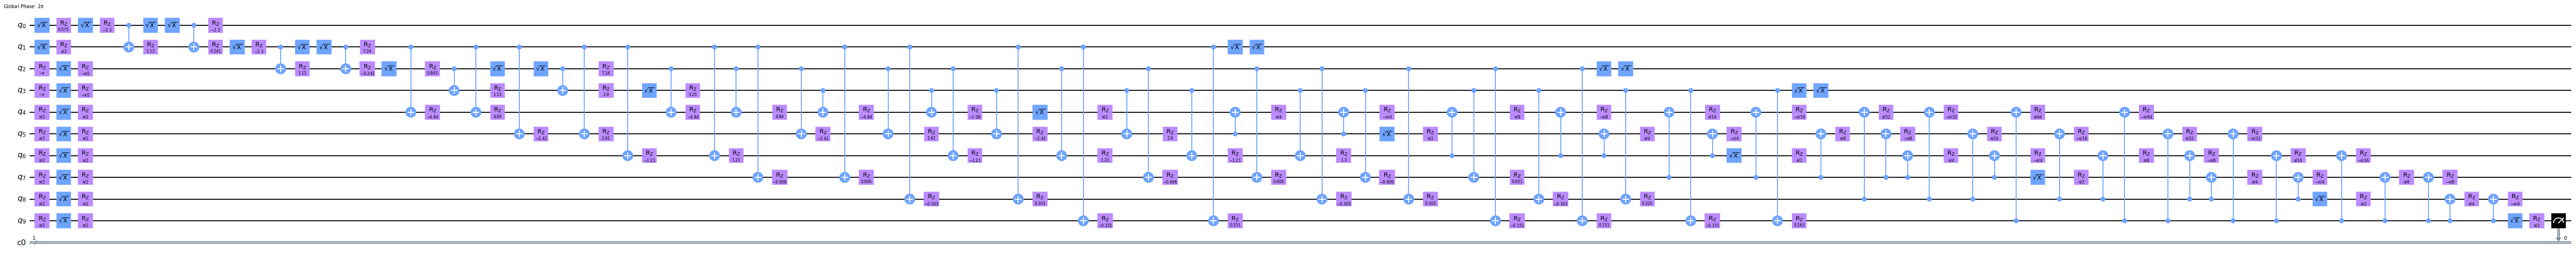

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm =  generate_preset_pass_manager(basis_gates = ['cx', 'sx', 'rz'], optimization_level=3,seed_transpiler=123,  layout_method='sabre',
                                       routing_method='sabre')

circuit_ibm = pm.run(circuit)
circuit_ibm.draw('mpl', idle_wires=False, fold=-1)

In [13]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2023
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.


"""Remove any swap gates in the circuit by pushing it through into a qubit permutation."""

import logging

from qiskit.circuit.library.standard_gates import SwapGate
from qiskit.circuit.library.generalized_gates import PermutationGate
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.layout import Layout

logger = logging.getLogger(__name__)


class ElidePermutations(TransformationPass):
    r"""Remove permutation operations from a pre-layout circuit

    This pass is intended to be run before a layout (mapping virtual qubits
    to physical qubits) is set during the transpilation pipeline. This
    pass iterates over the :class:`~.DAGCircuit` and when a :class:`~.SwapGate`
    or :class:`~.PermutationGate` are encountered it permutes the virtual qubits in
    the circuit and removes the swap gate. This will effectively remove any
    :class:`~SwapGate`\s or :class:`~PermutationGate` in the circuit prior to running
    layout. If this pass is run after a layout has been set it will become a no-op
    (and log a warning) as this optimization is not sound after physical qubits are
    selected and there are connectivity constraints to adhere to.

    For tracking purposes this pass sets 3 values in the property set if there
    are any :class:`~.SwapGate` or :class:`~.PermutationGate` objects in the circuit
    and the pass isn't a no-op.

    * ``original_layout``: The trivial :class:`~.Layout` for the input to this pass being run
    * ``original_qubit_indices``: The mapping of qubit objects to positional indices for the state
        of the circuit as input to this pass.
    * ``elision_final_layout``: A :class:`~.Layout` object mapping input qubits to the output
        state after eliding permutations.

    These three properties are needed for the transpiler to track the permutations in the out
    :attr:`.QuantumCircuit.layout` attribute. The elision of permutations is equivalent to a
    ``final_layout`` set by routing and all three of these attributes are needed in the case
    """

    def run(self, dag):
        """Run the ElidePermutations pass on ``dag``.

        Args:
            dag (DAGCircuit): the DAG to be optimized.

        Returns:
            DAGCircuit: the optimized DAG.
        """
        if self.property_set["layout"] is not None:
            logger.warning(
                "ElidePermutations is not valid after a layout has been set. This indicates "
                "an invalid pass manager construction."
            )
            return dag

        op_count = dag.count_ops()
        if op_count.get("swap", 0) == 0 and op_count.get("permutation", 0) == 0:
            return dag

        new_dag = dag.copy_empty_like()
        qubit_mapping = list(range(len(dag.qubits)))

        def _apply_mapping(qargs):
            return tuple(dag.qubits[qubit_mapping[dag.find_bit(qubit).index]] for qubit in qargs)

        for node in dag.topological_op_nodes():
            if not isinstance(node.op, (SwapGate, PermutationGate)):
                new_dag.apply_operation_back(node.op, _apply_mapping(node.qargs), node.cargs)
            elif getattr(node.op, "condition", None) is not None:
                new_dag.apply_operation_back(node.op, _apply_mapping(node.qargs), node.cargs)
            elif isinstance(node.op, SwapGate):
                index_0 = dag.find_bit(node.qargs[0]).index
                index_1 = dag.find_bit(node.qargs[1]).index
                qubit_mapping[index_1], qubit_mapping[index_0] = (
                    qubit_mapping[index_0],
                    qubit_mapping[index_1],
                )
            elif isinstance(node.op, PermutationGate):
                starting_indices = [qubit_mapping[dag.find_bit(qarg).index] for qarg in node.qargs]
                pattern = node.op.params[0]
                pattern_indices = [qubit_mapping[idx] for idx in pattern]
                for i, j in zip(starting_indices, pattern_indices):
                    qubit_mapping[i] = j
        input_qubit_mapping = {qubit: index for index, qubit in enumerate(dag.qubits)}
        self.property_set["original_layout"] = Layout(input_qubit_mapping)
        if self.property_set["original_qubit_indices"] is None:
            self.property_set["original_qubit_indices"] = input_qubit_mapping
        self.property_set["elision_final_layout"] = Layout(
            {dag.qubits[out]: idx for idx, out in enumerate(qubit_mapping)}
        )
        return new_dag

In [14]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag

In [15]:
swap_pass = ElidePermutations()

In [16]:
New_Dag = swap_pass(circuit)

In [17]:
from qiskit.compiler import transpile
backend = service.backend("ibmq_mumbai")
transp_cir_new = transpile(New_Dag,backend = backend, seed_transpiler=123, optimization_level = 3, layout_method='sabre',
                                       routing_method='sabre')

In [18]:
print('Transpiled Circuit: ', dict(transp_cir.count_ops()),'\n' ,
      #'Number of parallel layers:',num_layers(transp_cir), '\n', 
      'Depth of the circuit:', transp_cir.depth(), '\n',
    'Depth of the circuit: ElidePermutations:', transp_cir_new.depth(),'\n',)
     #'Number of parallel: layers ElidePermutations::',num_layers(transp_cir_new), )

Transpiled Circuit:  {'rz': 168, 'cx': 120, 'sx': 80, 'x': 8, 'barrier': 1, 'measure': 1} 
 Depth of the circuit: 142 
 Depth of the circuit: ElidePermutations: 141 



/nas/longleaf/home/jhmorga/.local/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


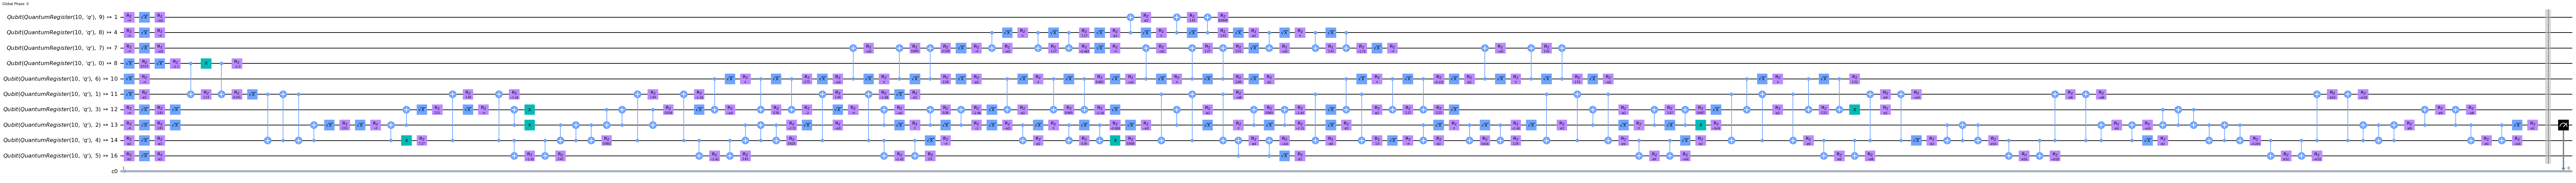

In [19]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm =  generate_preset_pass_manager(backend=backend, basis_gates = ['cx', 'sx', 'rz'], optimization_level=3,seed_transpiler=123,  layout_method='sabre',
                                       routing_method='sabre')

circuit_ibm = pm.run(New_Dag)
circuit_ibm.draw('mpl', idle_wires=False, fold=-1)

In [20]:
print('Transpiled Circuit: ', dict(circuit_ibm.count_ops()),'\n' , 
      'Depth of the circuit:', circuit_ibm.depth() )

Transpiled Circuit:  {'rz': 170, 'cx': 120, 'sx': 80, 'x': 7, 'barrier': 1, 'measure': 1} 
 Depth of the circuit: 141


In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler

options = Options()
options.resilience_level = 1
options.execution.shots = 1000

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

sampler = Sampler(backend=backend, options=options)
result = sampler.run(circuit_ibm).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.006818596040830016}


In [22]:
result.quasi_dists[0]

{0: 0.973, 1: 0.027}

In [24]:
import mapomatic as mm

In [25]:
small_qc = mm.deflate_circuit(circuit_ibm)

In [26]:
backends = service.backends()

mm.best_overall_layout(small_qc, backends, successors=True)

[([8, 11, 14, 23, 13, 21, 12, 15, 18, 17], 'ibmq_mumbai', 0.5741481040341286),
 ([18, 15, 12, 3, 10, 2, 7, 4, 1, 0], 'ibmq_kolkata', 0.5948080774440347),
 ([12, 15, 18, 19, 21, 22, 23, 24, 25, 26], 'ibm_cairo', 0.5996644744995518),
 ([3, 2, 1, 14, 4, 13, 7, 10, 12, 15], 'ibm_hanoi', 0.626494169134031)]

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler

options = Options()
options.transpilation.skip_transpilation = True

options.resilience_level = 1
options.execution.shots = 10000

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_mumbai")

sampler = Sampler(backend=backend, options=options)
result = sampler.run(circuit_ibm).result()
print(f">>> Metadata: {result.metadata[0]}")
##cn4m5vf3r3vg008fa85g

KeyboardInterrupt: 

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler

options = Options()
options.transpilation.skip_transpilation = True

options.resilience_level = 1
options.execution.shots = 10000

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_algiers")

sampler = Sampler(backend=backend, options=options)
result_alg = sampler.run(circuit_ibm).result()
print(f">>> Metadata: {result_alg.metadata[0]}")
# cn4m70wvayrg008ensn0

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# job_id = "cn4m70wvayrg008ensn0"  #### The Job executed on ibm_algiers the second best backend from Mapomatic
job_id = "cn4m5vf3r3vg008fa85g"    #### The Job executed on ibm_Mumbai the first best backend from Mapomatic
service = QiskitRuntimeService(channel="ibm_quantum")

job = service.job(job_id)

In [ ]:
Result_Hardware = job.result().quasi_dists[0]